In [27]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse, add_self_loops
from models.graph_water_transformer_cov import Graph_Water_Transformer_Cov
from torchinfo import summary
import torch.utils.data as data_utils

import math
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt

from preprocess.BaselinePrerocess import baseline_process
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5
from baselines.cnn import CNNGateGenerator
from losses.loss import gate_loss, water_level_threshold


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [3]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

In [4]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [5]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = torch.tensor(train_adj_mat), torch.tensor(val_adj_mat), torch.tensor(test_adj_mat)

In [7]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y = torch.tensor(train_X_mask), torch.tensor(val_X_mask), torch.tensor(test_X_mask), \
                                    torch.tensor(train_ws_y), torch.tensor(val_ws_y), torch.tensor(test_ws_y)

In [8]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y = torch.tensor(train_cov), torch.tensor(val_cov), torch.tensor(test_cov), \
                                torch.tensor(train_tws_reshape), torch.tensor(val_tws_reshape), torch.tensor(test_tws_reshape), \
                                torch.tensor(train_gate_pump_y), torch.tensor(val_gate_pump_y), torch.tensor(test_gate_pump_y), \
                                torch.tensor(train_ws_y), torch.tensor(val_ws_y), torch.tensor(test_ws_y)

C:\Users\User\AppData\Local\Temp\ipykernel_6716\3558344512.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_ws_y), torch.tensor(val_ws_y), torch.tensor(test_ws_y)


In [9]:
batch_size = 512*3
train_loader = data_utils.DataLoader(data_utils.TensorDataset(train_X_mask, train_tws_reshape, train_adj_mat), batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(data_utils.TensorDataset(val_X_mask, val_tws_reshape, val_adj_mat), batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(data_utils.TensorDataset(test_X_mask, test_tws_reshape, test_adj_mat), batch_size=batch_size, shuffle=True)

# batch_size = 512*3
# train_loader = data_utils.DataLoader(data_utils.TensorDataset(train_X_mask, train_tws_reshape, train_adj_mat, train_gate_pump_y, train_ws_y), batch_size=batch_size, shuffle=True)
# val_loader = data_utils.DataLoader(data_utils.TensorDataset(val_X_mask, val_tws_reshape, val_adj_mat, val_gate_pump_y, val_ws_y), batch_size=batch_size, shuffle=True)
# test_loader = data_utils.DataLoader(data_utils.TensorDataset(test_X_mask, test_tws_reshape, test_adj_mat, test_gate_pump_y, test_ws_y), batch_size=batch_size, shuffle=True)

In [10]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, next(iter(train_loader))[2].shape

(torch.Size([1536, 96, 16]),
 torch.Size([1536, 5, 72]),
 torch.Size([1536, 5, 5]))

### Model

#### Gate & pump predictor

In [11]:
# ===== model parameters ======
cnn_unit1 = 64
cnn_unit2 = 32
cnn_unit3 = 16
cnn_unit4 = 7
dropout = 0.0
kernel_size = 2
pool_size = 2
gate_min = 0.0
gate_max = 1.0

learning_rate = 3e-3
decay_steps = 10000
decay_rate = 0.9
PATIENCE = 100
EPOCHS = 700
BATCH = 512
input_shape = train_X_mask.shape[1:]
input_shape

torch.Size([96, 16])

In [12]:
GatePredictor = CNNGateGenerator(input_shape, cnn_unit1, cnn_unit2, cnn_unit3, cnn_unit4, 
                         kernel_size=3, dropout=0.5, pool_size=2, masked_value=None, gate_min=gate_min, gate_max=gate_max)
cov = torch.rand(1, 96, 16)
future_gate = GatePredictor(cov)
future_gate.shape

torch.Size([1, 24, 7])

In [13]:
# summary(model, input_data=inp)

#### water stage predictor

In [14]:
# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

input_shape = train_cov.shape[1:]
print(input_shape)

torch.Size([96, 12])


In [15]:
WSPredictor = Graph_Water_Transformer_Cov(input_shape,  num_heads, dropout, epsilon, lstm_units, num_transformer_blocks, gcn_unit1, gcn_unit2, ff_dim)
WSPredictor = WSPredictor.to(device)
WSPredictor.load_state_dict(torch.load(r"../saved_model/WaLeF_gtn_p.pth"))
for param in WSPredictor.parameters():
    param.requires_grad = False

In [17]:
cov = torch.rand(1, 96, 12).to(device)
tws = torch.rand(1, 5, 72).to(device)
edge = torch.rand(5, 5).to(device)
WSPredictor(cov, tws, edge).shape

torch.Size([1, 96])

#### Combine gate_predictor and trained ws_predictor

In [18]:
x_mask = torch.rand(1, 96, 16).to(device)

In [19]:
replaced_future_gate_pump = torch.concat([x_mask[:, n_hours:, :2], future_gate, x_mask[:, n_hours:, 9:]], dim=-1)

merged_inputs = torch.concat([x_mask[:, :n_hours, :], replaced_future_gate_pump], dim=1)
merged_inputs_cov = merged_inputs[:, :, :12]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [20]:
class FILDA(nn.Module):
    def __init__(self, n_hours):
        super(FILDA, self).__init__()
        self.n_hours = n_hours

        self.gate_predictor = GatePredictor.to(device)
        self.ws_predictor = WSPredictor.to(device)

    def forward(self, inputs_feat, inputs_tws, inputs_adj):
        self.ws_predictor.eval()
        gate_predictor_output = self.gate_predictor(inputs_feat) # future predicted gate-pump

        replaced_future_gate_pump = torch.cat((inputs_feat[:, self.n_hours:, :2], gate_predictor_output, inputs_feat[:, n_hours:, 9:]), dim=-1)
        merged_inputs = torch.cat((inputs_feat[:, :self.n_hours, :], replaced_future_gate_pump), dim=1)
        merged_inputs_cov = merged_inputs[:, :, :12]

        ws_pre = self.ws_predictor(merged_inputs_cov, inputs_tws, inputs_adj)

        return gate_predictor_output, ws_pre

model = FILDA(n_hours).to(device)

inputs_feat = torch.randn(10, 96, 16).to(device)
inputs_tws = torch.randn(10, 5, 72).to(device)
inputs_adj = torch.randn(5, 5).to(device)

output = model(inputs_feat, inputs_tws, inputs_adj)
gate_predictor_output = output[0]
ws_pred = output[1]

In [21]:
gate_loss(gate_predictor_output)

tensor(0., device='cuda:0', grad_fn=<AddBackward0>)

In [22]:
water_level_threshold(ws_pred)

tensor(15.1501, device='cuda:0', grad_fn=<AddBackward0>)

# Training

In [28]:
model = model.to(device)
train_losses = []
val_losses = []
total_num_epochs = 0

In [37]:

learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ExponentialLR(optimizer, gamma=decay_rate,
#                         #   last_epoch=-1
#                           )
# from torchmetrics.regression import MeanAbsoluteError
# criterion = torch.nn.MSELoss()
# MAE = MeanAbsoluteError().to(device)


num_epochs = 10

Epoch: 10 - Train Loss: 0.460 - Val Loss: 3.135


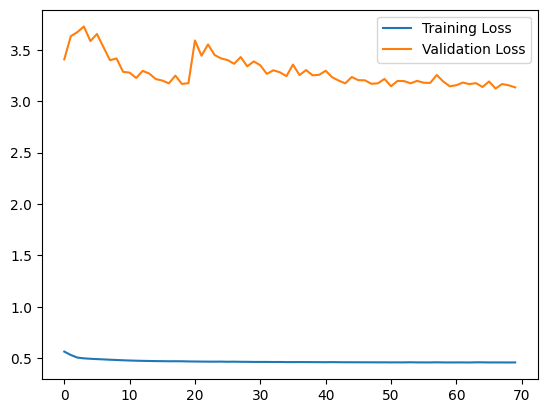

100%|██████████| 10/10 [01:35<00:00,  9.53s/it]


In [38]:
for epoch in tqdm(range(num_epochs)):
    total_num_epochs += epoch
    model.train()
    total_train_loss = 0
    
    for batch in train_loader:
        cov, tws, adj_mat = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        optimizer.zero_grad()
        gate_predictor_output, ws_pred = model(cov, tws, adj_mat[0])
        gate_pred_loss = gate_loss(gate_predictor_output)
        ws_pred_loss = water_level_threshold(ws_pred)
        loss = gate_pred_loss * 0 + ws_pred_loss * 2

        loss.backward()
        optimizer.step()
        # scheduler.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    total_val_loss = 0
    loader = val_loader
    with torch.no_grad():
        for batch in loader:
            cov, tws, adj_mat = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            gate_predictor_output, ws_pred = model(cov, tws, adj_mat[0])
            gate_pred_loss = gate_loss(gate_predictor_output)
            ws_pred_loss = water_level_threshold(ws_pred)
            loss = gate_pred_loss * 0 + ws_pred_loss * 2

            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(loader)
    val_losses.append(avg_val_loss)
    
    display.clear_output(wait=True)
    print(f"Epoch: {epoch+1} - Train Loss: {avg_train_loss:.3f} - Val Loss: {avg_val_loss:.3f}")
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.show(block=False)

    if len(val_losses) > 1:
        if val_losses[-1] < val_losses[-2]:
            torch.save(model.state_dict(), '../saved_model/cnn_gtnp_1.pth')



# Epoch 149: val_ws_predictor_loss did not improve from 1.71717
# 151/151 - 7s - loss: 0.4260 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2130 - val_loss: 3.4609 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7304 - 7s/epoch - 46ms/step
# Epoch 149: early stopping

# loss: 0.4260  --- val_loss: 3.4609
